In [1]:
from django.conf import settings
settings.configure(BASE_DIR='/Users/adammajczyk/Documents/AAA_Semy/Sem7/inzynierka/pracaInzynierska/djangoapp',)

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import sys
sys.path.append('/Users/adammajczyk/Documents/AAA_Semy/Sem7/inzynierka/pracaInzynierska') 

In [2]:
from djangoapp.news.scripts.llm import *
from djangoapp.news.scripts.model_loader2 import *
from djangoapp.news.scripts.nlp import *

In [3]:
import pandas as pd
import pickle  
from tqdm.notebook import tqdm 

df = pd.read_csv('../all_datasets/data/merged_titles_labels.csv')

In [4]:
df_test = df[df['sample'] == 'test'].reset_index(drop=True)
df_test

df_test_text = df_test[df_test['text'].notnull()].reset_index(drop=True)
df_test_no_text = df_test[df_test['text'].isnull()].reset_index(drop=True)

In [5]:
model_loader = ModelLoader()
llm = model_loader.llm 
vertex = model_loader.vertex
summarizer = model_loader.summarizer

## Testing VertexAI LLM

In [6]:
# ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
import copy as cp
datasets_vertex = {
    'df_test': df_test,
    # 'df_test_text': df_test_text,
    # 'df_test_no_text': df_test_no_text,
    # 'df_problem': df_problem,
}


for dataset_name in datasets_vertex.keys():
    if os.path.isfile('vertex_results.csv'):
        dataset = pd.read_csv('vertex_results.csv')
        continue

    dataset = cp.deepcopy(datasets_vertex[dataset_name])
    print(f'Predicting {dataset_name}...')
    dataset['with_summary_error'] = [False] * dataset.shape[0]
    dataset['without_summary_error'] = [False] * dataset.shape[0]

    for i, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
        title = row['title']
        if pd.notnull(row['text']):
            text = row['text']
            summary = model_loader.summarizer(
                text, max_length=200, min_length=40, do_sample=False
            )
            try:
                dataset.loc[i, 'vertex_prediction_with_summary'] = vertex.run(title, summary)
            except:
                print(f'Error in {i} row')
                dataset.loc[i, 'vertex_prediction_with_summary'] = None
                dataset.loc[i, 'with_summary_error'] = True
        else:
            dataset.loc[i, 'vertex_prediction_with_summary'] = None
        
        try:
            dataset.loc[i, 'vertex_prediction_without_summary'] = vertex.run(title)
        except:
            print(f'Error in {i} row')
            dataset.loc[i, 'vertex_prediction_without_summary'] = None
            dataset.loc[i, 'without_summary_error'] = True

Predicting df_test...


  0%|          | 0/2590 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (777 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
datasets_vertex['df_test'] = dataset
df_test = datasets_vertex['df_test']

In [ ]:
# save df
df_test.to_csv('vertex_results.csv', index=False)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Dane `title` (2585)

In [ ]:
df_test_no_text_no_nan = df_test[df_test['vertex_prediction_without_summary'].notnull()].reset_index(drop=True)
y_true = df_test_no_text_no_nan['is_clickbait'].values
y_pred = df_test_no_text_no_nan['vertex_prediction_without_summary'].values    

y_pred = y_pred.astype(int)

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

print(f'F1: {f1_score(y_true, y_pred):>15.4f}')
print(f'Recall: {recall_score(y_true, y_pred):>11.4f}')
print(f'Precision: {precision_score(y_true, y_pred):>8.4f}')
print(f'Accuracy: {accuracy_score(y_true, y_pred):>9.4f}')



F1:          0.7498
Recall:      0.9550
Precision:   0.6172
Accuracy:    0.6874


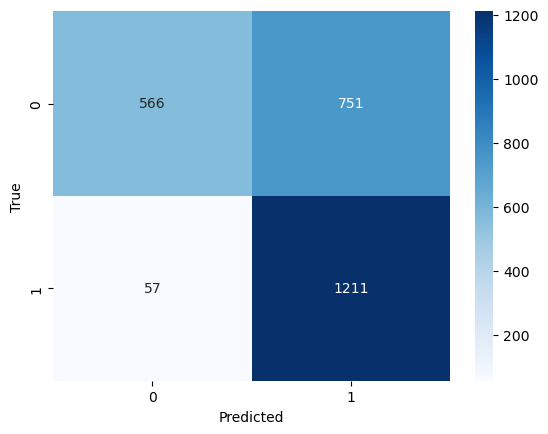

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# add labels to heatmap
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Dane `title + text` artykułów (992)

### Predykcja z podsumowaniem

In [ ]:
df_test_no_text_no_nan = df_test[df_test['vertex_prediction_with_summary'].notnull()].reset_index(drop=True)
y_true = df_test_no_text_no_nan['is_clickbait'].values
y_pred = df_test_no_text_no_nan['vertex_prediction_with_summary'].values

y_pred = y_pred.astype(int)

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

print(f'F1: {f1_score(y_true, y_pred):>15.4f}')
print(f'Recall: {recall_score(y_true, y_pred):>11.4f}')
print(f'Precision: {precision_score(y_true, y_pred):>8.4f}')
print(f'Accuracy: {accuracy_score(y_true, y_pred):>9.4f}')

F1:          0.7333
Recall:      0.7992
Precision:   0.6774
Accuracy:    0.7228


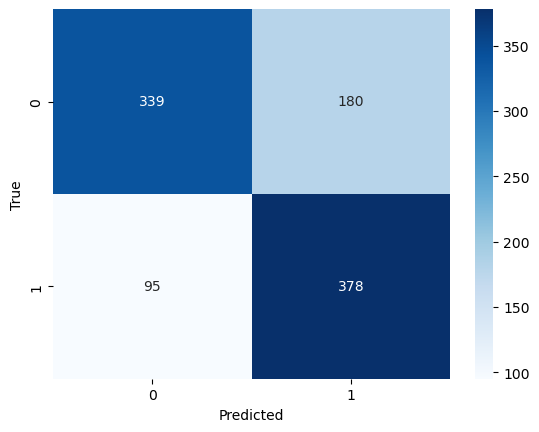

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# add labels to heatmap
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Predykcja bez podsumowania

In [ ]:
df_test_no_text_no_nan = df_test[df_test['vertex_prediction_with_summary'].notnull()].reset_index(drop=True)
y_true = df_test_no_text_no_nan['is_clickbait'].values
y_pred = df_test_no_text_no_nan['vertex_prediction_without_summary'].values

y_pred = y_pred.astype(int)

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score
print(f'F1: {f1_score(y_true, y_pred):>15.4f}')
print(f'Recall: {recall_score(y_true, y_pred):>11.4f}')
print(f'Precision: {precision_score(y_true, y_pred):>8.4f}')
print(f'Accuracy: {accuracy_score(y_true, y_pred):>9.4f}')

F1:          0.7265
Recall:      0.9239
Precision:   0.5986
Accuracy:    0.6683


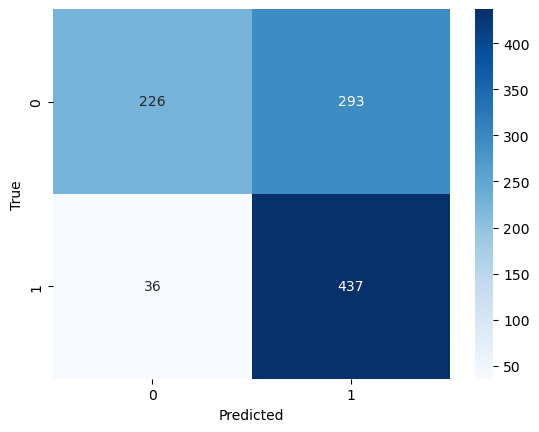

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# add labels to heatmap
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()